In [0]:
cd sample_data/

/content/sample_data


In [0]:
!mkdir models


In [0]:
!ls

anscombe.json		      mnist_test.csv	     README.md
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  models


In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1dhshM3TUzGfKeE3T-Sp1UYx6O2AR8CpS'}) # replace the id with id of file you want to access
downloaded.GetContentFile('fer2013.csv')  

#3. Read file as panda dataframe
import pandas as pd
data = pd.read_csv('fer2013.csv') 

    100% |████████████████████████████████| 993kB 2.2MB/s 

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
data.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [0]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Text(0.5, 1.0, 'Distribution of emotions,(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprised, 6=Neutral)')

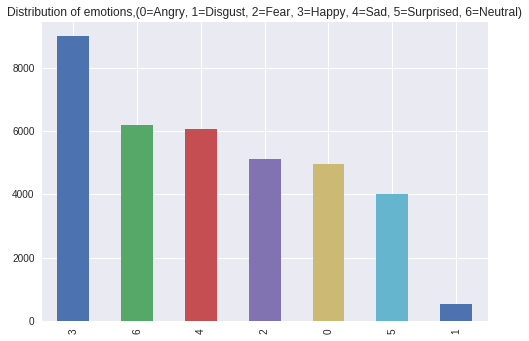

In [0]:
import matplotlib.pyplot as plt

data.emotion.value_counts().plot(kind='bar')
plt.title("Distribution of emotions,(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprised, 6=Neutral)")

Text(0.5, 1.0, 'Distribution of emotions,(0=Angry,1=Fear, 2=Happy, 3 = Sad, 4=Surprised, 5=Neutral)')

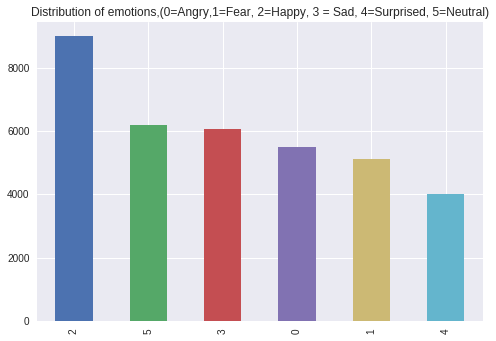

In [0]:
data['emotion'] = data['emotion'].map( {0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5} ).astype(int)
data.emotion.value_counts().plot(kind='bar')
plt.title("Distribution of emotions,(0=Angry,1=Fear, 2=Happy, 3 = Sad, 4=Surprised, 5=Neutral)")

Text(0.5, 1.0, 'Distribution of emotions,(0=Angry,1=Fear, 2=Happy, 3 = Sad, 4=Surprise, 5=Neutral)')

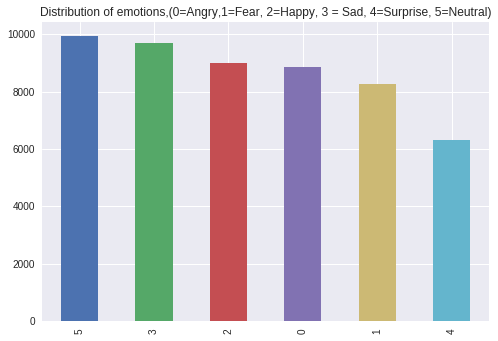

In [0]:
"Making copies of images to balance the class which prevents overfitting"
from sklearn.utils import shuffle

#As there are higher number of 'Happy' images, making copies of other images
df_copy = data[data.emotion != 2]
df_copy = df_copy[:int(0.6*len(df_copy.index))]
len(df_copy.index)
data_balanced = shuffle(pd.concat([data,df_copy]))

data_balanced.emotion.value_counts().plot(kind='bar')
plt.title("Distribution of emotions,(0=Angry,1=Fear, 2=Happy, 3 = Sad, 4=Surprise, 5=Neutral)")

In [0]:
data.iloc[0,1]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [0]:
import numpy as np
from keras.utils import np_utils
import pandas as pd

def process(data):
  #Seperating images data from labels ie emotion
  Y = []
  X = []
  for index, row in data.iterrows():
    Y.append(int(row["emotion"]))
    X.append([int(p) for p in row["pixels"].split()])

  X, Y = np.array(X) / 255.0, np.array(Y)  
  return X,Y

Using TensorFlow backend.


In [0]:
X,Y = process(data_balanced)

In [0]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)
num_class = len(set(Y))

# Split in  training set : validation set :  testing set in 80:10:10
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [0]:
label_map=["Angry","Fear","Happy","Sad","Surprise","Neutral"]

In [0]:
from matplotlib import pyplot as plt
plt.rcParams['axes.grid'] = False

def show_images(imgs,titles,rows=2,columns=5):
  fig=plt.figure(figsize=(12,12))
  for i in range(1,columns*rows+1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(imgs[i-1])
      plt.title(titles[i-1])
  plt.show()


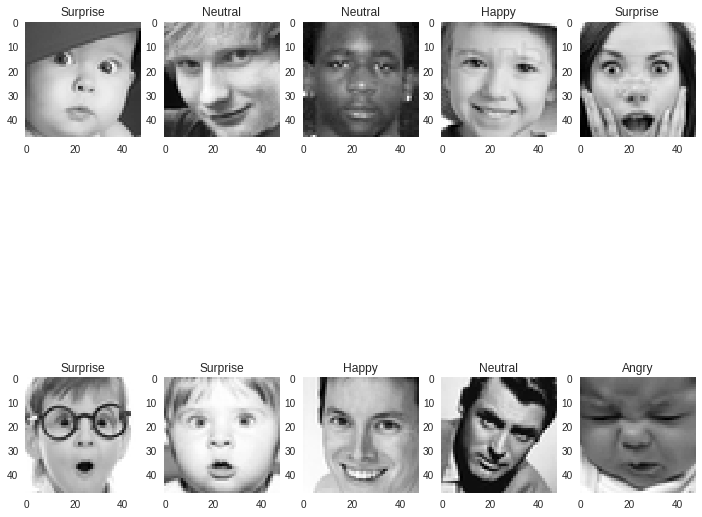

In [0]:
imgs=[X_train[i][:,:,0] for i in range(10)]
titles=[label_map[np.argmax(y_train[i])] for i in range(10)]
show_images(imgs,titles)

In [0]:
from keras.models import Sequential
from keras.optimizers import SGD,Adadelta
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D,AveragePooling2D
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import PReLU
import keras

def VGG():
    img_rows, img_cols = 48, 48
    model = Sequential()
    model.add(Convolution2D(64, 5, 5, border_mode='valid',
                            input_shape=(img_rows, img_cols, 1)))
    model.add(PReLU(init='zero', weights=None))
    model.add(ZeroPadding2D(padding=(2, 2), dim_ordering='tf'))
    model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(Convolution2D(64, 3, 3))
    model.add(PReLU(init='zero', weights=None))
    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(Convolution2D(64, 3, 3))
    model.add(PReLU(init='zero', weights=None))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(Convolution2D(128, 3, 3))
    model.add(PReLU(init='zero', weights=None))
    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(Convolution2D(128, 3, 3))
    model.add(PReLU(init='zero', weights=None))

    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(PReLU(init='zero', weights=None))
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(PReLU(init='zero', weights=None))
    model.add(Dropout(0.2))

    model.add(Dense(6))

    model.add(Activation('softmax'))

    ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer="rmsprop",
                  metrics=['accuracy'])
    
    return model

In [0]:
model = VGG()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(48, 48, 1..., padding="valid")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, alpha_initializer="zero")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D(padding=(2, 2), data_format="channels_last")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D(padding=(1, 1), data_format="channels_last")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 44, 44, 64)        123904    
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
p_re_lu_9 (PReLU)            (None, 22, 22, 64)        30976     
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, alpha_initializer="zero")`


In [0]:
batch_size = 256
epochs = 150

In [0]:

"""Dividing train data to train and validating set.
   Note: Use only while training using data augmentation"""

val_count = 3000 #Validation image number for data augmentation
val_x = X_train[:val_count]
val_y = y_train[:val_count]
train_x = X_train[val_count:]
train_y = y_train[val_count:]

In [0]:
"Training with augmented data. Augmentation takes place while training"

from keras.preprocessing.image import ImageDataGenerator

#Generate augmented data
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

valgen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False) 


In [0]:
datagen.fit(train_x)
valgen.fit(val_x)

In [0]:
# !rm -rf tblogs

In [0]:
#!mkdir tblogs

In [0]:
 #!rm -rf epochcsv.log

In [0]:
!touch epochcsv.log

In [0]:
import os
# include the epoch in the file name. (uses `str.format`)
checkpoint_path = "models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,period=3)
early_callback=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1,restore_best_weights=True)
reduceLR_callback=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=0.0001, cooldown=1, min_lr=0.00001)
# tb_callback=keras.callbacks.TensorBoard(log_dir='tblogs/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True)
csv_callback= keras.callbacks.CSVLogger('epochcsv.log', separator=',', append=False)
callbacks=[cp_callback,early_callback,reduceLR_callback,csv_callback]

In [0]:

model.fit_generator(datagen.flow(train_x, train_y,
                    batch_size=batch_size),
                    steps_per_epoch=len(train_x) /batch_size,
                    epochs=epochs,
                    validation_steps=20,
                    validation_data = valgen.flow(val_x, val_y,
                                                  
                    batch_size=batch_size),callbacks=callbacks,verbose = 1)

Epoch 1/150
138/171 [=======================>......] - ETA: 2:38 - loss: 1.8248 - acc: 0.1882